# Patient trial matching

In [1]:
import os
from pathlib import Path


# Get project directory
def get_project_dir():
    root = Path(os.path.expanduser("~"))
    return f"{root}/github/llm-drug-discovery"


project_dir = get_project_dir()
project_dir

'/home/mgustineli/github/llm-drug-discovery'

In [2]:
import re
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Create plots directory if it doesn't exist
os.makedirs(f"{project_dir}/plots", exist_ok=True)

# Load the simulated patient and trial data
with open(f"{project_dir}/data/train_patients.json", "r") as f:
    train_patient_data = json.load(f)

with open(f"{project_dir}/data/train_trials.json", "r") as f:
    train_trial_data = json.load(f)

with open(f"{project_dir}/data/test_patients.json", "r") as f:
    test_patient_data = json.load(f)

with open(f"{project_dir}/data/test_trials.json", "r") as f:
    test_trial_data = json.load(f)

In [3]:
# Function to extract structured data from patient text
def extract_patient_data(patient):
    """Extract structured data from patient record"""
    # Extract demographic information
    demographics = patient["demographics"].split(", ")
    gender = demographics[0]
    age = demographics[1].split(" ")[0]  # Extract just the number

    # Initialize patient data dictionary
    patient_data = {
        "id": patient["id"],
        "gender": gender,
        "age": int(age),
        "anaemia": 0,
        "diabetes": 0,
        "high_blood_pressure": 0,
        "smoking": 0,
        "ejection_fraction": None,
        "serum_creatinine": None,
        "serum_sodium": None,
    }

    # Parse medical history to extract conditions and measurements
    medical_history = patient["medical_history"]

    # Check for conditions
    if "Anaemia" in medical_history:
        patient_data["anaemia"] = 1
    if "Diabetes" in medical_history:
        patient_data["diabetes"] = 1
    if "High Blood Pressure" in medical_history:
        patient_data["high_blood_pressure"] = 1
    if "Smoker" in medical_history:
        patient_data["smoking"] = 1

    # Extract measurements using regex
    ef_match = re.search(r"Ejection Fraction: (\d+)%", medical_history)
    if ef_match:
        patient_data["ejection_fraction"] = int(ef_match.group(1))

    sc_match = re.search(r"Serum Creatinine: ([\d\.]+) mg/dL", medical_history)
    if sc_match:
        patient_data["serum_creatinine"] = float(sc_match.group(1))

    ss_match = re.search(r"Serum Sodium: (\d+) mEq/L", medical_history)
    if ss_match:
        patient_data["serum_sodium"] = int(ss_match.group(1))

    return patient_data


# Function to extract structured criteria from trial text
def extract_trial_criteria(trial):
    """Extract structured eligibility criteria from trial"""
    criteria_text = trial["eligibility_criteria"]["text"]

    # Initialize criteria dictionary
    criteria = {
        "id": trial["id"],
        "name": trial["name"],
        "age_min": None,
        "age_max": None,
        "ef_min": None,
        "ef_max": None,
        "creatinine_min": None,
        "creatinine_max": None,
        "sodium_min": None,
        "sodium_max": None,
        "anaemia": None,  # None means not specified
        "diabetes": None,
        "high_blood_pressure": None,
        "sex": None,
        "smoking": None,
    }

    # Extract age range
    age_match = re.search(r"Age between (\d+) and (\d+) years", criteria_text)
    if age_match:
        criteria["age_min"] = int(age_match.group(1))
        criteria["age_max"] = int(age_match.group(2))

    # Extract ejection fraction range
    ef_match = re.search(r"Ejection fraction between (\d+)% and (\d+)%", criteria_text)
    if ef_match:
        criteria["ef_min"] = int(ef_match.group(1))
        criteria["ef_max"] = int(ef_match.group(2))

    # Extract serum creatinine range
    sc_match = re.search(
        r"Serum creatinine between ([\d\.]+) and ([\d\.]+) mg/dL", criteria_text
    )
    if sc_match:
        criteria["creatinine_min"] = float(sc_match.group(1))
        criteria["creatinine_max"] = float(sc_match.group(2))

    # Extract serum sodium range
    ss_match = re.search(r"Serum sodium between (\d+) and (\d+) mEq/L", criteria_text)
    if ss_match:
        criteria["sodium_min"] = int(ss_match.group(1))
        criteria["sodium_max"] = int(ss_match.group(2))

    # Extract binary criteria
    if "With anaemia" in criteria_text:
        criteria["anaemia"] = 1
    elif "Without anaemia" in criteria_text:
        criteria["anaemia"] = 0

    if "With diabetes" in criteria_text:
        criteria["diabetes"] = 1
    elif "Without diabetes" in criteria_text:
        criteria["diabetes"] = 0

    if "With high blood pressure" in criteria_text:
        criteria["high_blood_pressure"] = 1
    elif "Without high blood pressure" in criteria_text:
        criteria["high_blood_pressure"] = 0

    if "Male patients only" in criteria_text:
        criteria["sex"] = "Male"
    elif "Female patients only" in criteria_text:
        criteria["sex"] = "Female"

    if "Current smokers" in criteria_text:
        criteria["smoking"] = 1
    elif "Non-smokers only" in criteria_text:
        criteria["smoking"] = 0

    return criteria


# Function to format patient data for text matching
def format_patient_for_text_matching(patient_data):
    """Format patient data in a way that aligns with trial criteria text"""
    text_parts = []

    # Format demographic information
    text_parts.append(f"Patient ID: {patient_data['id']}")
    text_parts.append(f"Age: {patient_data['age']} years")
    text_parts.append(f"Gender: {patient_data['gender']}")

    # Format conditions with consistent terminology
    if patient_data["anaemia"] == 1:
        text_parts.append("Has anaemia")
    else:
        text_parts.append("No anaemia")

    if patient_data["diabetes"] == 1:
        text_parts.append("Has diabetes")
    else:
        text_parts.append("No diabetes")

    if patient_data["high_blood_pressure"] == 1:
        text_parts.append("Has high blood pressure")
    else:
        text_parts.append("No high blood pressure")

    if patient_data["smoking"] == 1:
        text_parts.append("Is a smoker")
    else:
        text_parts.append("Is a non-smoker")

    # Format measurements with ranges to increase text overlap with criteria
    if patient_data["ejection_fraction"] is not None:
        ef = patient_data["ejection_fraction"]
        text_parts.append(f"Ejection fraction: {ef}%")
        # Add range descriptions that might match trial criteria
        if ef < 20:
            text_parts.append("Very low ejection fraction")
        elif ef < 30:
            text_parts.append("Low ejection fraction")
        elif ef < 45:
            text_parts.append("Moderately reduced ejection fraction")
        else:
            text_parts.append("Normal ejection fraction")

    if patient_data["serum_creatinine"] is not None:
        sc = patient_data["serum_creatinine"]
        text_parts.append(f"Serum creatinine: {sc} mg/dL")
        # Add range descriptions
        if sc < 0.7:
            text_parts.append("Low serum creatinine")
        elif sc < 1.2:
            text_parts.append("Normal serum creatinine")
        elif sc < 2.0:
            text_parts.append("Elevated serum creatinine")
        else:
            text_parts.append("High serum creatinine")

    if patient_data["serum_sodium"] is not None:
        ss = patient_data["serum_sodium"]
        text_parts.append(f"Serum sodium: {ss} mEq/L")
        # Add range descriptions
        if ss < 130:
            text_parts.append("Low serum sodium")
        elif ss < 135:
            text_parts.append("Slightly low serum sodium")
        elif ss <= 145:
            text_parts.append("Normal serum sodium")
        else:
            text_parts.append("High serum sodium")

    return " ".join(text_parts)


# Function to format trial criteria for text matching
def format_trial_for_text_matching(criteria):
    """Format trial criteria in a way that aligns with patient text"""
    text_parts = []

    # Basic trial information
    text_parts.append(f"Trial ID: {criteria['id']}")
    text_parts.append(f"Trial name: {criteria['name']}")

    # Format age criteria with consistent terminology
    if criteria["age_min"] is not None and criteria["age_max"] is not None:
        text_parts.append(
            f"Age between {criteria['age_min']} and {criteria['age_max']} years"
        )
        # Add age range descriptions
        if criteria["age_min"] >= 65:
            text_parts.append("For elderly patients")
        elif criteria["age_min"] >= 50:
            text_parts.append("For middle-aged and older patients")
        else:
            text_parts.append("For adult patients")

    # Format ejection fraction criteria
    if criteria["ef_min"] is not None and criteria["ef_max"] is not None:
        text_parts.append(
            f"Ejection fraction between {criteria['ef_min']}% and {criteria['ef_max']}%"
        )
        # Add range descriptions that might match patient text
        if criteria["ef_min"] < 20:
            text_parts.append("For very low ejection fraction")
        elif criteria["ef_min"] < 30:
            text_parts.append("For low ejection fraction")
        elif criteria["ef_min"] < 45:
            text_parts.append("For moderately reduced ejection fraction")
        else:
            text_parts.append("For normal ejection fraction")

    # Format serum creatinine criteria
    if (
        criteria["creatinine_min"] is not None
        and criteria["creatinine_max"] is not None
    ):
        text_parts.append(
            f"Serum creatinine between {criteria['creatinine_min']} and {criteria['creatinine_max']} mg/dL"
        )
        # Add range descriptions
        if criteria["creatinine_max"] <= 1.2:
            text_parts.append("For normal serum creatinine")
        elif criteria["creatinine_max"] <= 2.0:
            text_parts.append("For normal to elevated serum creatinine")
        else:
            text_parts.append("For patients with any serum creatinine level")

    # Format serum sodium criteria
    if criteria["sodium_min"] is not None and criteria["sodium_max"] is not None:
        text_parts.append(
            f"Serum sodium between {criteria['sodium_min']} and {criteria['sodium_max']} mEq/L"
        )
        # Add range descriptions
        if criteria["sodium_min"] < 130:
            text_parts.append("For low serum sodium")
        elif criteria["sodium_min"] < 135:
            text_parts.append("For slightly low to normal serum sodium")
        else:
            text_parts.append("For normal serum sodium")

    # Format binary criteria with consistent terminology
    if criteria["anaemia"] is not None:
        if criteria["anaemia"] == 1:
            text_parts.append("Requires anaemia")
            text_parts.append("Has anaemia")
        else:
            text_parts.append("Excludes anaemia")
            text_parts.append("No anaemia")

    if criteria["diabetes"] is not None:
        if criteria["diabetes"] == 1:
            text_parts.append("Requires diabetes")
            text_parts.append("Has diabetes")
        else:
            text_parts.append("Excludes diabetes")
            text_parts.append("No diabetes")

    if criteria["high_blood_pressure"] is not None:
        if criteria["high_blood_pressure"] == 1:
            text_parts.append("Requires high blood pressure")
            text_parts.append("Has high blood pressure")
        else:
            text_parts.append("Excludes high blood pressure")
            text_parts.append("No high blood pressure")

    if criteria["sex"] is not None:
        if criteria["sex"] == "Male":
            text_parts.append("For male patients only")
        else:
            text_parts.append("For female patients only")

    if criteria["smoking"] is not None:
        if criteria["smoking"] == 1:
            text_parts.append("For smokers only")
            text_parts.append("Is a smoker")
        else:
            text_parts.append("For non-smokers only")
            text_parts.append("Is a non-smoker")

    return " ".join(text_parts)


# Function to check if a patient meets trial criteria directly (rule-based)
def patient_meets_criteria(patient_data, trial_criteria):
    """Check if a patient meets trial eligibility criteria using rules"""
    # Check age criteria
    if (
        trial_criteria["age_min"] is not None
        and trial_criteria["age_max"] is not None
        and (
            patient_data["age"] < trial_criteria["age_min"]
            or patient_data["age"] > trial_criteria["age_max"]
        )
    ):
        return False

    # Check ejection fraction criteria
    if (
        trial_criteria["ef_min"] is not None
        and trial_criteria["ef_max"] is not None
        and patient_data["ejection_fraction"] is not None
        and (
            patient_data["ejection_fraction"] < trial_criteria["ef_min"]
            or patient_data["ejection_fraction"] > trial_criteria["ef_max"]
        )
    ):
        return False

    # Check serum creatinine criteria
    if (
        trial_criteria["creatinine_min"] is not None
        and trial_criteria["creatinine_max"] is not None
        and patient_data["serum_creatinine"] is not None
        and (
            patient_data["serum_creatinine"] < trial_criteria["creatinine_min"]
            or patient_data["serum_creatinine"] > trial_criteria["creatinine_max"]
        )
    ):
        return False

    # Check serum sodium criteria
    if (
        trial_criteria["sodium_min"] is not None
        and trial_criteria["sodium_max"] is not None
        and patient_data["serum_sodium"] is not None
        and (
            patient_data["serum_sodium"] < trial_criteria["sodium_min"]
            or patient_data["serum_sodium"] > trial_criteria["sodium_max"]
        )
    ):
        return False

    # Check binary criteria
    if (
        trial_criteria["anaemia"] is not None
        and patient_data["anaemia"] != trial_criteria["anaemia"]
    ):
        return False

    if (
        trial_criteria["diabetes"] is not None
        and patient_data["diabetes"] != trial_criteria["diabetes"]
    ):
        return False

    if (
        trial_criteria["high_blood_pressure"] is not None
        and patient_data["high_blood_pressure"] != trial_criteria["high_blood_pressure"]
    ):
        return False

    if (
        trial_criteria["smoking"] is not None
        and patient_data["smoking"] != trial_criteria["smoking"]
    ):
        return False

    # Check sex criteria
    if trial_criteria["sex"] is not None:
        if (trial_criteria["sex"] == "Male" and patient_data["gender"] != "Male") or (
            trial_criteria["sex"] == "Female" and patient_data["gender"] != "Female"
        ):
            return False

    # If all criteria are met, return True
    return True

In [4]:
# Process all patients and trials with the new formatting functions
print("Processing patient and trial data with enhanced text formatting...")
processed_train_patients = []
for patient in train_patient_data:
    patient_data = extract_patient_data(patient)
    enhanced_text = format_patient_for_text_matching(patient_data)
    processed_train_patients.append(
        {
            "id": patient["id"],
            "data": patient_data,
            "text": enhanced_text,
            "original": patient,
        }
    )

processed_test_patients = []
for patient in test_patient_data:
    patient_data = extract_patient_data(patient)
    enhanced_text = format_patient_for_text_matching(patient_data)
    processed_test_patients.append(
        {
            "id": patient["id"],
            "data": patient_data,
            "text": enhanced_text,
            "original": patient,
        }
    )

processed_train_trials = []
for trial in train_trial_data:
    criteria = extract_trial_criteria(trial)
    enhanced_text = format_trial_for_text_matching(criteria)
    processed_train_trials.append(
        {
            "id": trial["id"],
            "criteria": criteria,
            "text": enhanced_text,
            "eligible_patients": trial["eligible_patients"],
            "original": trial,
        }
    )

processed_test_trials = []
for trial in test_trial_data:
    criteria = extract_trial_criteria(trial)
    enhanced_text = format_trial_for_text_matching(criteria)
    processed_test_trials.append(
        {
            "id": trial["id"],
            "criteria": criteria,
            "text": enhanced_text,
            "eligible_patients": trial["eligible_patients"],
            "original": trial,
        }
    )

print("Data processing complete.")

# Create TF-IDF vectorizer for text similarity
print("Training TF-IDF vectorizer...")
# Combine all texts for training the vectorizer
all_texts = [p["text"] for p in processed_train_patients] + [
    t["text"] for t in processed_train_trials
]
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
vectorizer.fit(all_texts)

Processing patient and trial data with enhanced text formatting...
Data processing complete.
Training TF-IDF vectorizer...


TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

In [5]:
# Hybrid function to match patients with clinical trials using both rule-based and TF-IDF
def match_patients_with_trials(patients, trials, vectorizer, threshold=0.1):
    """
    Match patients with clinical trials using both rule-based and TF-IDF approaches
    Returns a dictionary of trial_id -> list of matched patient_ids
    """
    matches = {}

    # Vectorize all patient texts
    patient_texts = [p["text"] for p in patients]
    patient_vectors = vectorizer.transform(patient_texts)

    for trial in trials:
        trial_id = trial["id"]
        matches[trial_id] = []

        # Vectorize trial text
        trial_vector = vectorizer.transform([trial["text"]])

        # Calculate similarity between trial and all patients
        similarities = cosine_similarity(trial_vector, patient_vectors).flatten()

        # Find patients that meet criteria and have similarity above threshold
        for i, patient in enumerate(patients):
            similarity = similarities[i]

            # Check if patient meets criteria directly
            meets_criteria = patient_meets_criteria(patient["data"], trial["criteria"])

            # Use a hybrid approach: either rule-based match or high similarity
            if meets_criteria or similarity >= threshold:
                # Calculate a combined score (weighted average of rule-based and similarity)
                combined_score = 0.7 * float(meets_criteria) + 0.3 * float(similarity)

                matches[trial_id].append(
                    {
                        "patient_id": patient["id"],
                        "match_probability": combined_score,
                        "meets_criteria": meets_criteria,
                        "similarity": float(similarity),
                    }
                )

    return matches


# Function to evaluate matching performance
def evaluate_matching(matches, trials):
    """
    Evaluate the performance of the matching algorithm
    """
    results = {
        "trial_id": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "num_predicted": [],
        "num_actual": [],
        "num_correct": [],
    }

    for trial in trials:
        trial_id = trial["id"]
        actual_matches = set(trial["eligible_patients"])
        predicted_matches = set([m["patient_id"] for m in matches.get(trial_id, [])])

        # Calculate metrics
        correct_matches = actual_matches.intersection(predicted_matches)

        precision = (
            len(correct_matches) / len(predicted_matches) if predicted_matches else 0
        )
        recall = len(correct_matches) / len(actual_matches) if actual_matches else 1.0
        f1 = (
            2 * precision * recall / (precision + recall)
            if (precision + recall) > 0
            else 0
        )

        # Store results
        results["trial_id"].append(trial_id)
        results["precision"].append(precision)
        results["recall"].append(recall)
        results["f1"].append(f1)
        results["num_predicted"].append(len(predicted_matches))
        results["num_actual"].append(len(actual_matches))
        results["num_correct"].append(len(correct_matches))

    # Calculate overall metrics
    overall_precision = np.mean(results["precision"])
    overall_recall = np.mean(results["recall"])
    overall_f1 = np.mean(results["f1"])

    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")

    return pd.DataFrame(results)


# Optimize threshold using training data
print("Optimizing matching threshold...")
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
threshold_results = []

for threshold in thresholds:
    print(f"Testing threshold: {threshold}")
    matches = match_patients_with_trials(
        processed_train_patients, processed_train_trials, vectorizer, threshold
    )
    evaluation = evaluate_matching(matches, processed_train_trials)
    threshold_results.append(
        {
            "threshold": threshold,
            "precision": np.mean(evaluation["precision"]),
            "recall": np.mean(evaluation["recall"]),
            "f1": np.mean(evaluation["f1"]),
        }
    )

# Find best threshold
threshold_df = pd.DataFrame(threshold_results)
best_threshold = threshold_df.loc[threshold_df["f1"].idxmax(), "threshold"]
print(f"Best threshold: {best_threshold}")

Optimizing matching threshold...
Testing threshold: 0.05
Overall Precision: 0.1159
Overall Recall: 0.8422
Overall F1 Score: 0.1869
Testing threshold: 0.1
Overall Precision: 0.5194
Overall Recall: 0.8422
Overall F1 Score: 0.5510
Testing threshold: 0.15
Overall Precision: 0.9386
Overall Recall: 0.8422
Overall F1 Score: 0.8724
Testing threshold: 0.2
Overall Precision: 1.0000
Overall Recall: 0.8422
Overall F1 Score: 0.9090
Testing threshold: 0.25
Overall Precision: 1.0000
Overall Recall: 0.8422
Overall F1 Score: 0.9090
Testing threshold: 0.3
Overall Precision: 1.0000
Overall Recall: 0.8422
Overall F1 Score: 0.9090
Best threshold: 0.2


Evaluating on test set...
Overall Precision: 0.6667
Overall Recall: 0.1497
Overall F1 Score: 0.2435
Generating matching report...
Evaluation complete! Results saved to /home/mgustineli/github/llm-drug-discovery/data/
Visualizations saved to /home/mgustineli/github/llm-drug-discovery/plots/


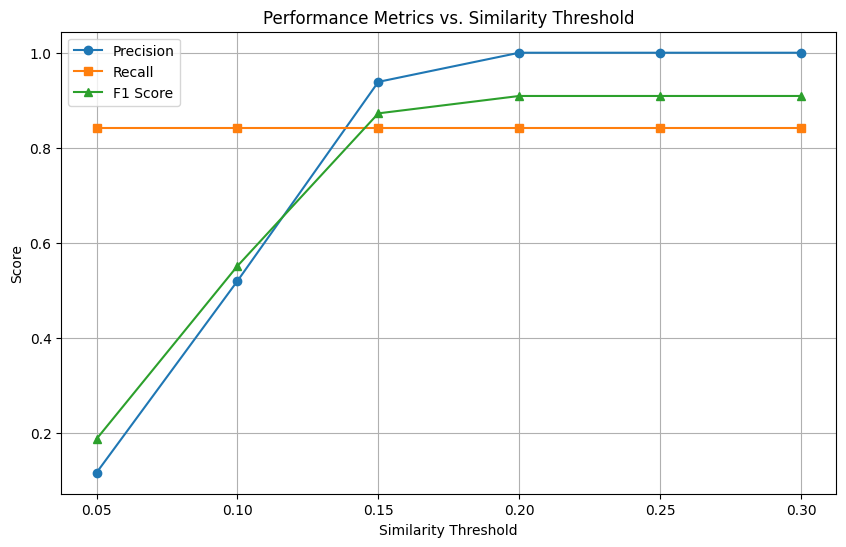

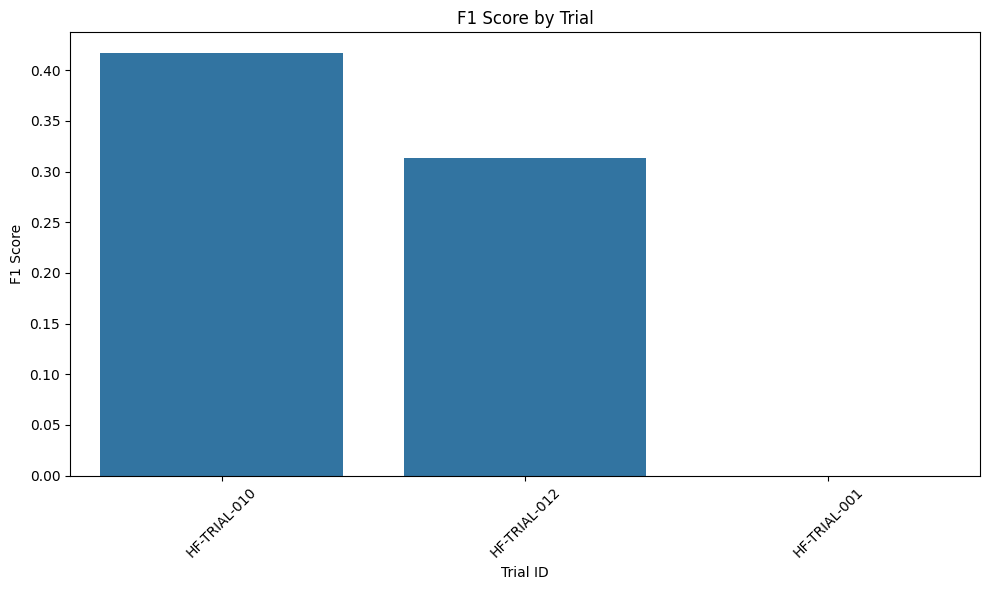

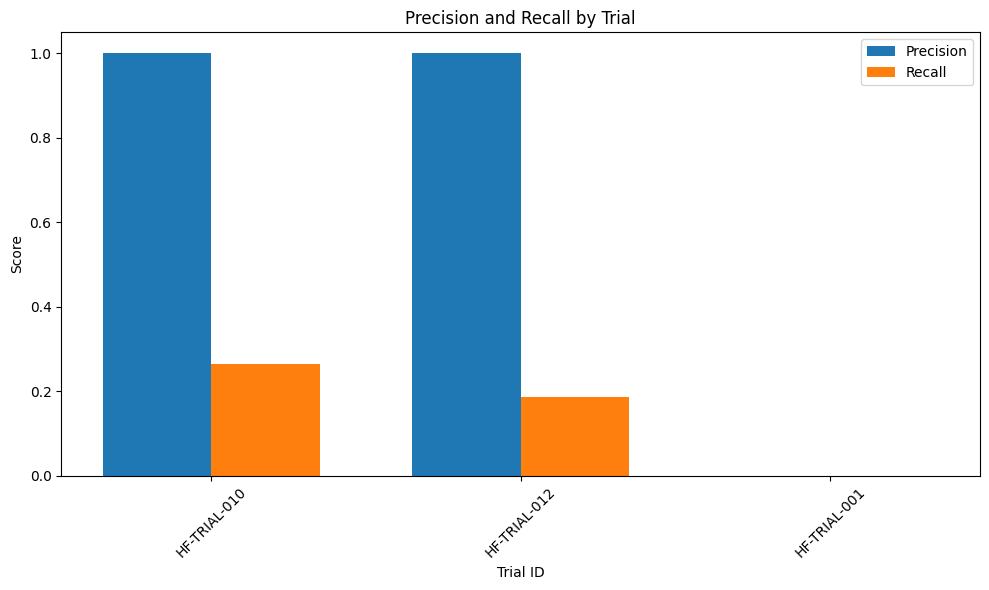

In [6]:
# Plot threshold results
plt.figure(figsize=(10, 6))
plt.plot(
    threshold_df["threshold"], threshold_df["precision"], marker="o", label="Precision"
)
plt.plot(threshold_df["threshold"], threshold_df["recall"], marker="s", label="Recall")
plt.plot(threshold_df["threshold"], threshold_df["f1"], marker="^", label="F1 Score")
plt.xlabel("Similarity Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs. Similarity Threshold")
plt.legend()
plt.grid(True)
plt.savefig(f"{project_dir}/plots/threshold_optimization.png")

# Evaluate on test set with best threshold
print("Evaluating on test set...")
test_matches = match_patients_with_trials(
    processed_test_patients, processed_test_trials, vectorizer, best_threshold
)
test_evaluation = evaluate_matching(test_matches, processed_test_trials)

# Save evaluation results
test_evaluation.to_csv(f"{project_dir}/data/matching_evaluation.csv", index=False)

# Convert trial_id to string type to ensure proper categorical handling
test_evaluation["trial_id"] = test_evaluation["trial_id"].astype(str)

# Visualize evaluation results - F1 Score
plt.figure(figsize=(10, 6))
# Use categorical plot with explicit order to ensure all trials are shown
ax = sns.barplot(x="trial_id", y="f1", data=test_evaluation)
plt.title("F1 Score by Trial")
plt.xlabel("Trial ID")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
# Ensure all trial IDs are shown
plt.tight_layout()
plt.savefig(f"{project_dir}/plots/f1_by_trial.png")

# Plot precision-recall comparison - FIXED to ensure all trials are displayed
plt.figure(figsize=(10, 6))
# Create a categorical x-axis with all trial IDs
trial_ids = test_evaluation["trial_id"].tolist()
x = np.arange(len(trial_ids))
width = 0.35

# Plot bars with explicit x positions
plt.bar(x - width / 2, test_evaluation["precision"], width, label="Precision")
plt.bar(x + width / 2, test_evaluation["recall"], width, label="Recall")
plt.xlabel("Trial ID")
plt.ylabel("Score")
plt.title("Precision and Recall by Trial")
# Explicitly set x-tick positions and labels
plt.xticks(x, trial_ids, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(f"{project_dir}/plots/precision_recall_by_trial.png")


# Create a function to generate patient-trial matching report
def generate_matching_report(patients, trials, matches):
    """Generate a detailed report of patient-trial matches"""
    report = []

    # Create patient lookup
    patient_lookup = {p["id"]: p for p in patients}

    for trial in trials:
        trial_id = trial["id"]
        trial_matches = matches.get(trial_id, [])

        # Sort matches by probability
        trial_matches.sort(key=lambda x: x["match_probability"], reverse=True)

        # Get trial information
        trial_name = trial["criteria"]["name"]
        description = trial["original"]["description"]
        criteria = trial["original"]["eligibility_criteria"]["text"]

        report.append(f"Trial: {trial_id} - {trial_name}")
        report.append(f"Description: {description}")
        report.append(f"Eligibility Criteria: {criteria}")
        report.append(f"Number of matched patients: {len(trial_matches)}")
        report.append("Top 5 matched patients:")

        for i, match in enumerate(trial_matches[:5], 1):
            patient_id = match["patient_id"]
            patient = patient_lookup.get(patient_id, {})

            # Format match details
            report.append(f"  {i}. Patient ID: {patient_id}")
            report.append(f"     Match probability: {match['match_probability']:.4f}")
            report.append(
                f"     Meets criteria directly: {'Yes' if match.get('meets_criteria', False) else 'No'}"
            )
            report.append(
                f"     Text similarity score: {match.get('similarity', 0):.4f}"
            )

            # Format patient details
            if "original" in patient:
                demographics = patient["original"]["demographics"]
                medical_history = patient["original"]["medical_history"]
                report.append(f"     Demographics: {demographics}")
                report.append(f"     Medical History: {medical_history}")

        report.append("\n" + "-" * 80 + "\n")

    return "\n".join(report)


# Generate and save matching report
print("Generating matching report...")
matching_report = generate_matching_report(
    processed_test_patients, processed_test_trials, test_matches
)
with open(f"{project_dir}/data/matching_report.txt", "w") as f:
    f.write(matching_report)

print(f"Evaluation complete! Results saved to {project_dir}/data/")
print(f"Visualizations saved to {project_dir}/plots/")


In [8]:
test_evaluation["trial_id"]

0    HF-TRIAL-010
1    HF-TRIAL-012
2    HF-TRIAL-001
Name: trial_id, dtype: object